In [1]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
__author__ = 'Author'
__email__ = 'Email'

# Detecting Contradiction at the Lexical Level
## Hopythesis 1

**Hypothesis:**

> A text $T = P + H$ involves a contradiction if and only if there exists a **startle word** $w_h$ in hypothesis $H$, such that the probability of $w_h$ conditioned on the premise $P$ is significantly lower than its probability when conditioned only on the preceding context within $H$.

Formally:

$$
P(w_h \mid P + H_{<w_h}) \ll P(w_h \mid H_{<w_h})
$$

Where:

* $P$ is the premise,
* $H$ is the hypothesis, and $H_{<w_h}$ is the context within $H$ before $w_h$,
* $w_h$ is the startle word, signaling a contradiction.

### Example (as you provided, slightly refined):

**Premise (P)**: *Daniel is in the hallway.*
**Hypothesis (H)**: *Daniel is in the bedroom.*

Compute probabilities:

* **Prob1** $= P(\text{"bedroom"} \mid \text{"Daniel is in the"})$
* **Prob2** $= P(\text{"bedroom"} \mid \text{"Daniel is in the hallway. Daniel is in the"})$

**Contradiction signal**: Prob1 significantly exceeds Prob2, i.e., Prob1 ≫ Prob2.

### Justification:

* If a contradiction exists, the model should judge the startle word (**"bedroom"** here) improbable after reading the premise.
* Without the premise, this improbability disappears, indicating that the drop in probability directly measures the presence of contradiction.

This hypothesis clearly aligns with your approach of reducing contradiction detection to lexical-level modeling, where shifts in lexical probability directly encode the presence of contradictions.


In [201]:
# dependency
# built-in
import os, math, random, string
# # public
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import matplotlib.pyplot as plt
import seaborn as sns
# private
from transformers import AutoModelForCausalLM, AutoTokenizer
from config import Config


%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Helper

In [79]:
# Global dictionary mapping model IDs (or model families) to BOW prefixes
BOW_PREFIX_MAP = {
    "meta-llama/Llama-3.2-3B": "Ġ", # LLaMA 2, 3
    "deepseek-ai": "Ġ",             # DeepSeek
    "EleutherAI/gpt-neo": "Ġ",      # GPT-Neo
    "openai-community/gpt2": "Ġ",   # GPT-2
    "facebook/opt": "Ġ",            # OPT family
    "bigscience/bloom": "▁",        # BLOOM uses SentencePiece
    "google/pegasus": "▁",          # SentencePiece
    "google-t5": "▁",               # T5 models
    "google/mt5": "▁",
    "Salesforce/codegen": "Ġ",      # CodeGen uses GPT-style
}

def get_device():
    if "DEVICE" in os.environ:
        return os.environ["DEVICE"]
    if torch.cuda.is_available():
        return "cuda"
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return "mps"
    elif hasattr(torch, "xpu") and torch.xpu.is_available():
        return "xpu"
    return "cpu"

def set_random_seed(seed: int = 42):
    """Fix random seeds for reproducibility across Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # Ensures deterministic behavior where possible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class Beam:
    # BOW prefix ID for the model
    bow_prefix_id = None
    def __init__(self, token_ids, token_probs, input_ids, parent=None):
        """
        Args:
            token_ids (List[int]): List of token IDs generated so far
            token_probs (List[float]): List of probabilities for each token in the beam
            input_ids (List[int]): Full input IDs (prompt + generated tokens)
            parent (Optional[Beam]): Parent beam for backtracking
        """
        self.token_ids = token_ids
        self.token_probs = token_probs
        self.token_log_probs = [math.log(p) if p > 0 else float('-inf') for p in token_probs]
        self.input_ids = input_ids
        self.parent = parent

    def extend(self, next_token_id, next_token_prob):
        """Return a new Beam with one more token added."""
        return Beam(
            self.token_ids + [next_token_id],
            self.token_probs + [next_token_prob],
            self.input_ids + [next_token_id],
            parent=self
        )

    def prob(self):
        """Return product of token probabilities (pseudo-probability)."""
        return math.prod(self.token_probs) if self.token_ids else .0

    def log_prob(self):
        """Return sum of log probabilities (more stable for ranking)."""
        return sum(self.token_log_probs)

    @property
    def done(self):
        """A beam is done if the last token is a BOW token (end of word)."""
        return self.token_ids and self.token_ids[-1] == Beam.bow_prefix_id

    def path(self):
        """Return a list of beam nodes from root to this beam."""
        beam, result = self, []
        while beam:
            result.append(beam)
            beam = beam.parent
        return list(reversed(result))

    def decoded(self, tokenizer):
        """Decode the beam's token sequence using a tokenizer."""
        return tokenizer.decode(self.token_ids)

    def tokens(self, tokenizer):
        """Return a list of token strings."""
        return [tokenizer.decode([t]) for t in self.token_ids]

    def __eq__(self, other):
        return isinstance(other, Beam) and self.token_ids == other.token_ids

    def __hash__(self):
        return hash(tuple(self.token_ids))

    def __repr__(self):
        return f"Beam(tokens={self.token_ids}, prob={self.prob():.8f}, log_prob={self.log_prob():.8f})"    


# Init

In [ ]:
config = Config()
for k,v in config.__dict__.items():
    print(f'{k}: {v}')

# init model and tokenizer
config.device = get_device()
print(f"Using device: {config.device}")

tokenizer = AutoTokenizer.from_pretrained(
    config.LLM_PATH
    , device_map=config.device
    )

model = AutoModelForCausalLM.from_pretrained(
    config.LLM_PATH
    , device_map=config.device
    )

detokenizer = TreebankWordDetokenizer()

# init parameters
beam_width = 1  # for the taget word probability

config.bow_prefix = BOW_PREFIX_MAP.get(config.LLM_PATH, "Ġ")
config.bow_prefix_id = tokenizer.convert_tokens_to_ids(config.bow_prefix)
print(f'bow prefix: {config.bow_prefix}')
print(f'bow prefix id: {config.bow_prefix_id}')

Beam.bow_prefix_id = config.bow_prefix_id


seed: 0
llm: meta-llama/Llama-3.2-3B
beam_depth: 10
CURR_PATH: ./
RESOURCE_PATH: ./res
DATA_PATH: ./res/data
RESULTS_PATH: ./res/results
LLMS_PATH: ./res/llms
LLM_PATH: ./res/llms/meta-llama/Llama-3.2-3B
Using device: mps


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

bow prefix: Ġ
bow prefix id: 220


# I/O

In [43]:
input_tsv = 'res/data/wiki/capital50_con.tsv'
input_df = pd.read_csv(input_tsv, sep='\t')

ps = input_df['premise'].tolist()
hs = input_df['hypothesis'].tolist()
ys = input_df['label'].tolist()
input_df.head(5)

,wikidata_id,country,capital,premise,hypothesis,label
0,Q233,Malta,Valletta,The capital of Malta is Valletta.,The capital of Malta is Valletta.,False
1,Q233,Malta,Brasília,The capital of Malta is Valletta.,The capital of Malta is Brasília.,True
2,Q262,Algeria,Algiers,The capital of Algeria is Algiers.,The capital of Algeria is Algiers.,False
3,Q262,Algeria,Dakar,The capital of Algeria is Algiers.,The capital of Algeria is Dakar.,True
4,Q889,Afghanistan,Kabul,The capital of Afghanistan is Kabul.,The capital of Afghanistan is Kabul.,False


# Llama 3

In [81]:
def lm(text_or_ids, model, tokenizer, config):
    """
    Compute the next-token probability distribution for a given input.

    Args:
        text_or_ids (str or List[int]): Input string or list of token IDs
        model: Hugging Face AutoModelForCausalLM
        tokenizer: Corresponding tokenizer
        config: Should contain `.device`

    Returns:
        probs (Tensor): Softmax probability distribution over vocabulary, shape [vocab_size]
    """
    # Decode token IDs to text if input is not a string
    if not isinstance(text_or_ids, str):
        text = tokenizer.decode(text_or_ids, skip_special_tokens=True)
    else:
        text = text_or_ids

    # Tokenize input
    x = tokenizer(text, return_tensors="pt")
    input_ids = x["input_ids"].to(config.device)
    attention_mask = x["attention_mask"].to(config.device)

    # Run model and get logits for the last token
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits[:, -1, :]  # Last token position
    probs = F.softmax(logits, dim=-1).squeeze()  # [vocab_size]

    return probs

def norm_probs(probs, valid_token_ids):
    """
    Normalize probs over a precomputed set of valid token IDs.

    Args:
        probs (Tensor): Raw probability distribution over vocabulary, shape [vocab_size]
        valid_token_ids (List[int]): Token IDs that are considered valid for normalization

    Returns:
        norm_probs (Tensor): New probability distribution normalized over valid_token_ids
    """
    masked_probs = torch.zeros_like(probs)
    masked_probs[valid_token_ids] = probs[valid_token_ids]
    total = masked_probs.sum()

    return masked_probs / total

def inject_eow_prob(probs, bow_token_ids, bow_prefix_id):
    """
    Inject EOW probability into the bow_prefix_id slot by reallocating 
    the total BOW mass there, and zeroing out the original BOW tokens.
    
    Returns a new probability tensor (not in-place).
    """
    probs = probs.clone()
    bow_mass = probs[bow_token_ids].sum()
    probs[bow_token_ids] = 0.0
    probs[bow_prefix_id] = bow_mass
    return probs

def is_bow_token(token_id, bow_prefix, tokenizer) -> bool:
    """
    Returns True if the token is a valid token:
    - start with the BOW prefix
    - contains only alphanumeric characters
    """
    return tokenizer.convert_ids_to_tokens(token_id).startswith(bow_prefix)

def get_bow_token_ids(bow_prefix, tokenizer) -> list:
    """
    Returns a list of token IDs that:
    - start with the BOW prefix (e.g., Ġ), AND
    - decode to alphabetic strings (i.e., isalpha())
    """
    vocab_size = tokenizer.vocab_size
    return [i for i in range(vocab_size) if is_bow_token(i, bow_prefix, tokenizer)]

def is_mid_token(token_id, bow_prefix, tokenizer) -> bool:
    """
    Returns True if the token is a valid continuation of a word:
    - does NOT start with the BOW prefix
    - contains only English letters
    """
    token = tokenizer.convert_ids_to_tokens(token_id)
    token_str = tokenizer.decode(token_id)
    # take care of some special cases
    # N'Djamena; Sana’a
    token_str = ''.join([l for l in token_str if l not in string.punctuation])
    # does NOT start with the BOW prefix
    if token.startswith(bow_prefix):
        return False
    # contains only English letters
    if not token_str.isalpha():
        return False
    return True


def get_mid_token_ids(bow_prefix, tokenizer) -> list:
    """
    Returns a list of token IDs that:
    - start with the BOW prefix (e.g., Ġ), AND
    - decode to alphabetic strings (i.e., isalpha())
    """
    vocab_size = tokenizer.vocab_size
    return [i for i in range(vocab_size) if is_mid_token(i, bow_prefix, tokenizer)]

# get valid token ids
bow_token_ids = get_bow_token_ids(config.bow_prefix, tokenizer)
print(f"Bow token IDs: {len(bow_token_ids)}")

mid_token_ids = get_mid_token_ids(config.bow_prefix, tokenizer)
print(f"Mid token IDs: {len(mid_token_ids)}")

valid_token_ids = list(set(bow_token_ids + mid_token_ids))
print(f"Valid token IDs: {len(valid_token_ids)}")

print(config.LLM_PATH)

Bow token IDs: 57875
Mid token IDs: 60451
Valid token IDs: 118326
./res/llms/meta-llama/Llama-3.2-3B


In [340]:
# test
idx = random.choice(range(len(ps)))
idx = 1
p = ps[idx]
h = hs[idx]
y = ys[idx]
print(f'premise: {p}')
print(f'hypothesis: {h}')
print(f'label: {y}')

premise: The capital of Malta is Valletta.
hypothesis: The capital of Malta is Brasília.
label: True


# Target Word Probability Calculation 

In [360]:
def get_tgt_word_beams(h, p=''):
    ws_h = word_tokenize(h)
    # print(ws_p)
    h_beams = []
    # for i in trange(len(ws_h)):
    for i in range(len(ws_h)):
        # i = 5
        prev_ws = ws_h[:i]
        print(prev_ws)
        tgt_w = ws_h[i]
        print(tgt_w)
        tgt_tks = tokenizer(' ' + tgt_w, add_special_tokens=False).input_ids + [config.bow_prefix_id]
        # print(tokenizer.convert_ids_to_tokens(tgt_tks))
        context = p + ' ' + detokenizer.detokenize(prev_ws)
        # print(prev_ws) 
        print(context)
        input_ids = tokenizer(context, return_tensors="pt").input_ids.tolist()[0]
        # print(input_ids)
        # print(tokenizer.convert_ids_to_tokens(input_ids))
        beam = Beam([], [], input_ids)
        for depth, tgt_token in enumerate(tgt_tks):
            # print(beam, depth, tgt_token)
            # Get next-token probability distribution
            next_probs = lm(beam.input_ids, model, tokenizer, config)
            # print(next_probs)
            vocab_ids = bow_token_ids if depth == 0 else valid_token_ids
            next_probs = norm_probs(next_probs, vocab_ids)
            # print(tgt_token, tgt_token in vocab_ids)
            # print(next_probs[tgt_token])
            # Inject end-of-word (EOW) probability at depths > 0
            if depth == len(tgt_tks) - 1:
                next_probs = inject_eow_prob(next_probs, bow_token_ids, config.bow_prefix_id)
            tgt_prob = next_probs[tgt_token].item()
            # print(tgt_prob)
            beam = beam.extend(tgt_token, tgt_prob)
            # break
        h_beams.append(beam)
    return h_beams


h = 'The capital of Bharatpur State is Bharatpur.'
h_beams = get_tgt_word_beams(h)


[]
The
 
['The']
capital
 The
['The', 'capital']
of
 The capital
['The', 'capital', 'of']
Bharatpur
 The capital of
['The', 'capital', 'of', 'Bharatpur']
State
 The capital of Bharatpur
['The', 'capital', 'of', 'Bharatpur', 'State']
is
 The capital of Bharatpur State
['The', 'capital', 'of', 'Bharatpur', 'State', 'is']
Bharatpur
 The capital of Bharatpur State is
['The', 'capital', 'of', 'Bharatpur', 'State', 'is', 'Bharatpur']
.
 The capital of Bharatpur State is Bharatpur


In [362]:
for b in h_beams:
    print(b)
    print(b.decoded(tokenizer))
    print(b.tokens(tokenizer))
    print(b.log_prob())
    print(b.prob())
    print('---')

Beam(tokens=[578, 220], prob=0.00086288, log_prob=-7.05523006)
 The 
[' The', ' ']
-7.055230061286424
0.0008628841979981504
---
Beam(tokens=[6864, 220], prob=0.00019591, log_prob=-8.53786093)
 capital 
[' capital', ' ']
-8.537860925009367
0.00019590887603914038
---
Beam(tokens=[315, 220], prob=0.61097548, log_prob=-0.49269846)
 of 
[' of', ' ']
-0.49269845605112783
0.6109754772491307
---
Beam(tokens=[67692, 266, 26047, 220], prob=0.00000217, log_prob=-13.03998707)
 Bharatpur 
[' Bhar', 'at', 'pur', ' ']
-13.039987066090939
2.1717287119928496e-06
---
Beam(tokens=[3314, 220], prob=0.02248850, log_prob=-3.79475127)
 State 
[' State', ' ']
-3.7947512723214607
0.022488498633221443
---
Beam(tokens=[374, 220], prob=0.33291090, log_prob=-1.09988038)
 is 
[' is', ' ']
-1.0998803790479923
0.3329109044356571
---
Beam(tokens=[67692, 266, 26047, 220], prob=0.04622019, log_prob=-3.07433857)
 Bharatpur 
[' Bhar', 'at', 'pur', ' ']
-3.074338567956036
0.046220189788023086
---
Beam(tokens=[662, 220], pr

In [330]:
h_beams = get_tgt_word_beams(h)
# hp_beams = get_tgt_word_beams(h, p)

In [331]:
for h_beam in h_beams:
    print('h_word', h_beam.decoded(tokenizer), h_beam.prob(), h_beam.log_prob())

h_word  The  0.0008628841979981504 -7.055230061286424
h_word  capital  0.00019590887603914038 -8.537860925009367
h_word  of  0.6109754772491307 -0.49269845605112783
h_word  Finland  0.0026408448773293514 -5.936656383730942
h_word  is  0.7045434342484569 -0.3502052969555455
h_word  Kabul  2.768935337617198e-07 -15.099632759293085
h_word .  0.03075959820998042 -3.4815531965242683


# Hopythesis 1

In [257]:
# get target word beams
hs_beams = []
hps_beams = []
for p, h in zip(tqdm(ps), hs):
    # print(f'premise: {p}')
    # print(f'hypothesis: {h}')
    # step 1 h alone
    h_beams = get_tgt_word_beams(h)
    # step 2 h + p
    hp_beams = get_tgt_word_beams(h, p)
    hs_beams.append(h_beams)
    hps_beams.append(hp_beams)

100%|██████████| 100/100 [04:29<00:00,  2.69s/it]


In [350]:
for prob_change_threshold in [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]:
    log_prob_change_threshold = math.log(prob_change_threshold)
    print(f'prob change threshold: {prob_change_threshold}')
    print(f'log prob change threshold: {log_prob_change_threshold}')
    # h is nautral by itself
    # hp is contradictory when p is introduced
    # so the prob change should be negative
    ys_ = []
    for h_beams in hs_beams:
        y_ = False
        for h_beam in h_beams:
            # print('h_word', h_beam.decoded(tokenizer), h_beam.prob(), h_beam.log_prob())
            # h_word_log_prob = h_beam.log_prob() - h_beam.log_prob()
            if h_beam.log_prob() < log_prob_change_threshold:
                y_ = True
                break
        ys_.append(y_)
    # calculate the accuracy
    ys = np.array(ys)
    ys_ = np.array(ys_)
    print(f'Accuracy: {np.mean(ys == ys_):.4f}')
    print('----')
    # break

prob change threshold: 0.1
log prob change threshold: -2.3025850929940455
Accuracy: 0.5000
----
prob change threshold: 0.01
log prob change threshold: -4.605170185988091
Accuracy: 0.5000
----
prob change threshold: 0.001
log prob change threshold: -6.907755278982137
Accuracy: 0.5000
----
prob change threshold: 0.0001
log prob change threshold: -9.210340371976182
Accuracy: 0.9700
----
prob change threshold: 1e-05
log prob change threshold: -11.512925464970229
Accuracy: 0.9300
----
prob change threshold: 1e-06
log prob change threshold: -13.815510557964274
Accuracy: 0.8600
----


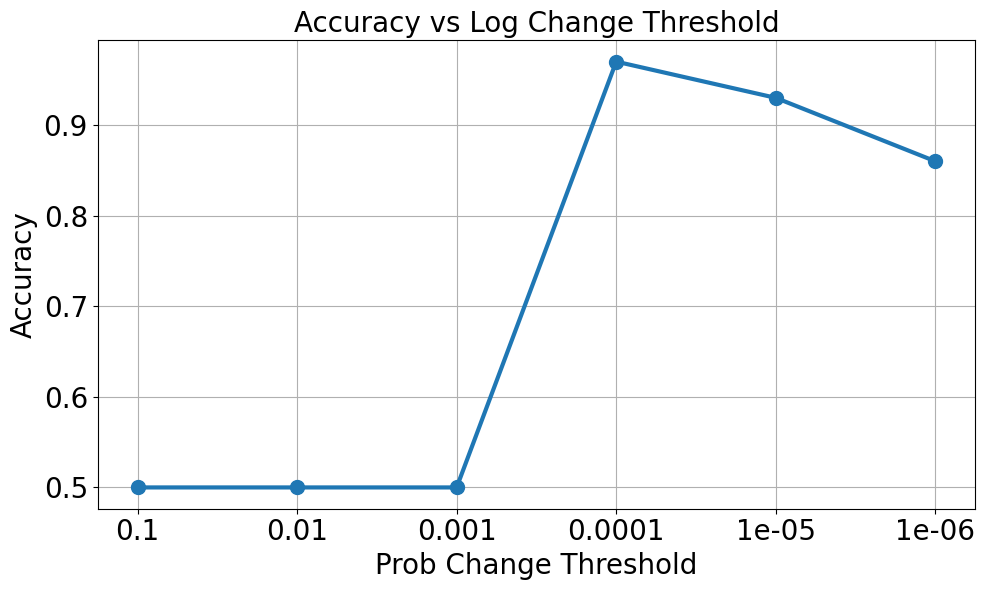

In [381]:
# line chart shoowing the accuracy with log prob change threshold
prob_change_thresholds = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
log_prob_change_thresholds = [math.log(prob_change_threshold) for prob_change_threshold in prob_change_thresholds]
prob_change_thresholds = [str(_) for _ in prob_change_thresholds]
log_prob_change_thresholds = [str(_) for _ in log_prob_change_thresholds]
accs = [0.5, 0.5, 0.5, 0.97, 0.93, 0.86]

plt.figure(figsize=(10, 6))
# from lower accuracy to higher accuracy
plt.plot(
    prob_change_thresholds
    , accs
    , marker='o'
    , markersize=10
    , linewidth=3
    )
plt.xticks(prob_change_thresholds, prob_change_thresholds, fontsize=20)
# change the font size of y axis
plt.yticks(fontsize=20)
plt.xlabel('Prob Change Threshold', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy vs Log Change Threshold', fontsize=20)
# plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess')
# plt.legend(fontsize=20)
# plt.xlim(min(log_prob_change_thresholds), max(log_prob_change_thresholds))
# plt.ylim(0, 1)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

In [351]:
# best attempt
prob_change_threshold = 0.0001
log_prob_change_threshold = math.log(prob_change_threshold)
print(f'prob change threshold: {prob_change_threshold}')
print(f'log prob change threshold: {log_prob_change_threshold}')

startle_ws, startle_w_probs, startle_w_log_probs, ys_ = [], [], [], []
for h_beams in hs_beams:
    startle_w, startle_w_prob, startle_w_log_prob, y_ = None, None, None, False
    for h_beam in h_beams:
        # print('h_word', h_beam.decoded(tokenizer), h_beam.prob(), h_beam.log_prob())
        # h_word_log_prob = h_beam.log_prob() - h_beam.log_prob()
        if h_beam.log_prob() < log_prob_change_threshold:
            startle_w = h_beam.decoded(tokenizer).strip()
            startle_w_prob = h_beam.prob()
            startle_w_log_prob = h_beam.log_prob()
            y_ = True
            break
    ys_.append(y_)
    startle_ws.append(startle_w)
    startle_w_probs.append(startle_w_prob)
    startle_w_log_probs.append(startle_w_log_prob)


prob change threshold: 0.0001
log prob change threshold: -9.210340371976182


In [352]:
# save outputs
output_df = pd.DataFrame({
    'premise': ps
    , 'hypothesis': hs
    , 'label': ys
    , 'startle_word': startle_ws
    , 'startle_word_prob': startle_w_probs
    , 'startle_word_log_prob': startle_w_log_probs
    , 'predicted_label': ys_
})
output_df.to_csv('res/results/lm/con/capital_50.tsv', sep='\t', index=False)

## Case Study

In [594]:
h = 'John is in the kitchen.'
p = 'Since John is in the bedroom,'
h_beams = get_tgt_word_beams(h, p)
h_words = [b.decoded(tokenizer) for b in h_beams]
h_log_probs = [b.log_prob() for b in h_beams]


[]
John
Since John is in the bedroom, 
['John']
is
Since John is in the bedroom, John
['John', 'is']
in
Since John is in the bedroom, John is
['John', 'is', 'in']
the
Since John is in the bedroom, John is in
['John', 'is', 'in', 'the']
kitchen
Since John is in the bedroom, John is in the
['John', 'is', 'in', 'the', 'kitchen']
.
Since John is in the bedroom, John is in the kitchen


In [595]:
def get_heatmap(words, probs):
    # Convert to 2D numpy arrays
    probs = np.array([probs])
    words = np.array([words], dtype=object)

    # Plot heatmap
    plt.figure(figsize=(12, 1.5))
    sns.heatmap(
        probs
        ,annot=words
        ,fmt=''
        ,cmap="viridis"
        ,xticklabels=False
        ,yticklabels=False
        ,cbar_kws={"label": "log probability"}
        )

    plt.tight_layout()
    plt.show()

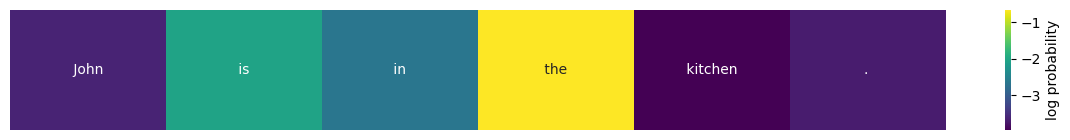

In [596]:
get_heatmap(h_words, h_log_probs)

In [576]:
h = 'My name is K'
next_probs = lm(h, model, tokenizer, config)

In [577]:
top_probs, top_ids = torch.topk(next_probs, 20)
top_ids = top_ids.tolist()
top_probs = top_probs.tolist()
top_words = tokenizer.convert_ids_to_tokens(top_ids)
for i in range(len(top_ids)):
    print(f'{top_words[i]}: {top_probs[i]:.4f}')

elsey: 0.0632
ait: 0.0406
ari: 0.0214
ately: 0.0208
ira: 0.0188
atar: 0.0186
ieran: 0.0182
elli: 0.0162
ater: 0.0155
ell: 0.0141
eri: 0.0136
ail: 0.0126
av: 0.0126
ev: 0.0105
sen: 0.0099
yla: 0.0099
ase: 0.0098
ish: 0.0097
asia: 0.0093
.: 0.0088


In [542]:
tgt_id = tokenizer.convert_tokens_to_ids('ĠO')
tgt_prob = next_probs[tgt_id].item()
print(f'{tgt_id}: {tgt_prob}')

507: 0.00014790866407565773
